In [76]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

#### Plot peak positions vs true wavelength for one order

Text(0, 0.5, 'Wavelength / Å')

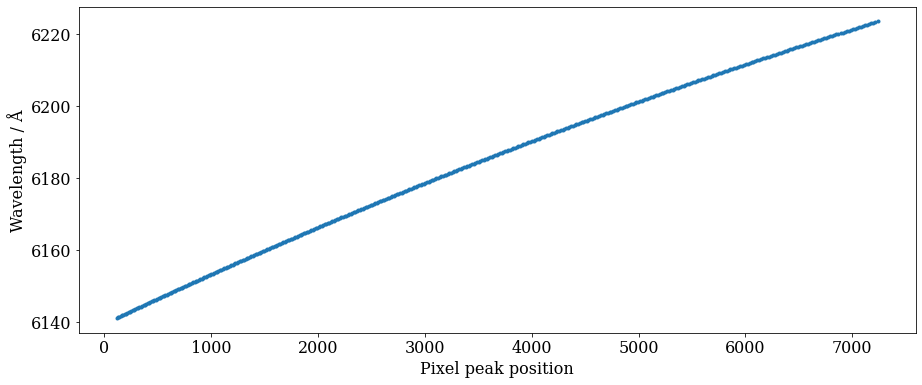

In [75]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

order = 61
data = hdu1[1].data.copy()
data_spec       = data['spectrum'][order]
data_spec_err   = data['uncertainty'][order]
data_wavel      = data['wavelength'][order]

# Find peaks
peak_info = func_find_peaks(data_spec, 11, 0.15)
peak_locs = peak_info[0]

# Create data slices around each peak
peak_index_ranges = get_peak_index_ranges(peak_locs)

# Fit peak in each data slice
peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

# Get list of true wavelengths
wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

# Plot
plt.figure(figsize=(15,6))
plt.plot(peak_fits[:,2], wavel_true, ".")
plt.xlabel("Pixel peak position")
plt.ylabel("Wavelength / Å")

#### Analyze all orders

In [39]:
# Load data
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

data = hdu1[1].data.copy()

# order = 61
orders = np.arange(0, len(data['spectrum']))

results = []
for order in tqdm.tqdm(orders):
    data_spec       = data['spectrum'][order]
    data_spec_err   = data['uncertainty'][order]
    data_wavel      = data['wavelength'][order]

    # Find peaks
    peak_info = func_find_peaks(data_spec, 11, 0.15)
    peak_locs = peak_info[0]

    if len(peak_locs) == 0:
        results.append([order, [[np.nan]], [[np.nan]], [np.nan] ]) # save NaN to list if no peak
        continue

    # Create data slices around each peak
    peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size = 14)    # TODO: find dynamic way of choosing range size

    # Fit peak in each data slice
    peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

    # Get list of true wavelengths
    wavel_true = get_true_wavel(data_wavel, peak_locs)
    
    results.append([order, peak_fits, wavel_true, data_wavel[peak_locs]])

    # Plot
    # plt.figure(figsize=(8,4))
    # plt.plot(peak_locs, wavel_true[:,0], ".")
    # plt.plot(peak_fits[:,2], wavel_true[:,0], ".")
    # plt.title(f"{order}. order")
    # plt.xlabel("Pixel peak position")
    # plt.ylabel("Wavelength / Å")

results = np.asarray(results)

100%|██████████| 86/86 [00:20<00:00,  4.10it/s]


#### Number of peaks per order

Text(0.5, 1.0, 'Number of peaks per order')

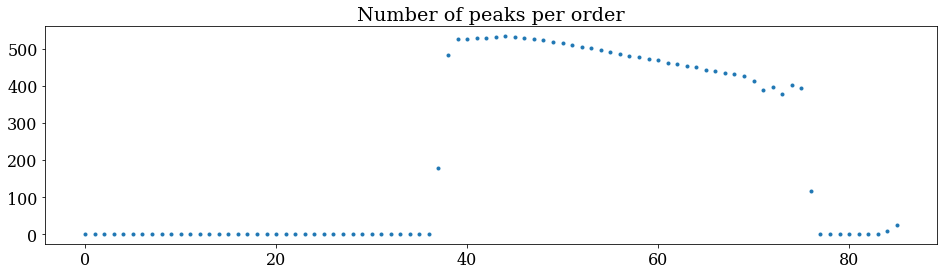

In [40]:
# Plot number of peaks per order
plt.figure(figsize=(16,4))
plt.plot(np.arange(len(results[:, 1])), [len(k) for k in results[:, 1]], ".")
plt.title("Number of peaks per order")

#### All calibration curves in one plot

Text(0.5, 1.0, 'Calibration curves (for orders 37-76)')

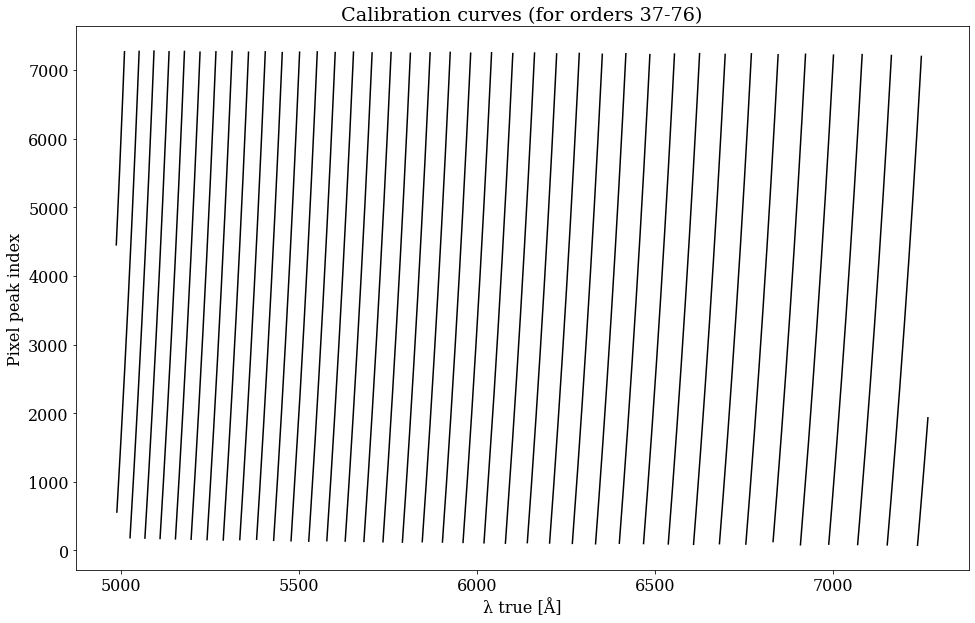

In [6]:
orders = results[:, 0]
peak_fits = results[:, 1]
wavel_true = results[:, 2]
wavel_given = results[:, 3]

plt.figure(figsize=(16,10))
for order in range(37, 77):
    plt.plot(wavel_true[order][:, 0], peak_fits[order][:,2], "k")

plt.xlabel("λ true [Å]")
plt.ylabel("Pixel peak index")
plt.title("Calibration curves (for orders 37-76)")
# plt.savefig("figures/calibration_curves.png", dpi=300)

#### Mean chi2 for each order

In [7]:
# TODO :: find way to compute mean chi2 for each order

# chi2_val_means = []
# for fit_vals in results[:, 1]:
#     print(fit_vals)
    # order_chi2 = []
    # for fit_val in fit_vals:
    #     if len(fit_val) > 1:
    #         order_chi2.append(fit_val[4])
    # chi2_val_means.append(np.mean(order_chi2))
    

    # if len(k) == 4:
    #     print(k)

# for res in results:
#     if res[]

#     if not np.isnan(peak_fit[0][0]):
#         chi2_vals = peak_fit[:, 4]
#         chi2_val_means.append(np.mean(chi2_vals))

# plt.figure(figsize=(16,8))
# plt.plot(np.arange(len(chi2_val_means)), chi2_val_means, ".")
# plt.title("Number of peaks per order")


### Save peak fits data to parquet file

In [8]:
orders = results[:, 0]
peak_fits = results[:, 1]
wavel_true = results[:, 2]
wavel_given = results[:, 3]

table = []

# Columns: peak_id, A, mu, sigma, P, c, b, ν_n, λ_true_peak, λ_approx_peak, x_min, x_max, χ², converged, valid, std_A, std_μ, std_σ, std_P, std_c, std_b, order

# for order in range(37, max(orders)):
for order in orders:
    for peak in range(len(peak_fits[order])):

        # Get fit values for peaks
        peak_fit =  peak_fits[order][peak]

        if(len(peak_fit) == 1):
            # no peak_fit
            # A, A_err, mu, mu_err, sigma, sigma_err, C, C_err, chi2_val, ndof, converged, pixmin, pixmax = [np.nan] * 13
            # lambd = np.nan
            # lambd_n = np.nan
            continue # skip to next order
        else: 
            A, A_err, mu, mu_err, sigma, sigma_err, C, C_err, chi2_val, ndof, converged, pixmin, pixmax = peak_fit
            lambd = wavel_true[order][peak][0]
            lambd_n = wavel_true[order][peak][1]
    
        # Assemble row
        row = [
            A,
            mu,
            sigma, 
            np.nan,                         # P
            np.nan,                         # c
            np.nan,                         # b
            lambd_n,                        # ν_n
            lambd,                          # λ_true_peak
            wavel_given[order][peak],       # wavel_given
            pixmin,                         # xmin
            pixmax,                         # xmax
            chi2_val,                       # chi2
            converged,                      # converged
            np.nan,                         # valid
            A_err,                          # A err
            mu_err,                         # mu err
            sigma_err,                      # sigma err
            np.nan,                         # P err
            np.nan,                         # c err
            np.nan,                         # b err
            int(order)
         ]
        table.append(row)


columns = ["A", "μ", "σ", "P", "c", "b", "ν_n", "λ_true_peak", "λ_approx_peak", "x_min", "x_max", "χ²", "converged", "valid", "std_A", "std_μ", "std_σ", "std_P", "std_c", "std_b", "order"]
rows = np.asarray(table, dtype=object)
df = pd.DataFrame(rows, columns=columns)
# df.to_excel("data/fit_params.xlsx") 
# df.to_parquet('data/fit_params.parquet')

# Display DataFrame
pd.options.display.max_columns = None
pd.options.display.max_rows = 20
# pd.options.display.min_rows = 100
pd.set_option('display.expand_frame_repr', True)
df

,A,μ,σ,P,c,b,ν_n,λ_true_peak,λ_approx_peak,x_min,x_max,χ²,converged,valid,std_A,std_μ,std_σ,std_P,std_c,std_b,order
0,0.307664,5782.603885,0.25032,NaN,NaN,NaN,55749.0,3841.069287,3841.072784,5776.0,5790.0,7.644111,1.0,NaN,1.605023,0.330083,0.324071,NaN,NaN,NaN,0
1,0.094192,5882.394362,0.667096,NaN,NaN,NaN,55740.0,3841.689477,3841.676638,5870.0,5884.0,10.973235,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0
2,0.330616,6014.285015,10.754669,NaN,NaN,NaN,55379.0,3866.732161,3866.747817,6008.0,6022.0,13.320936,1.0,NaN,0.110335,0.767191,3.043321,NaN,NaN,NaN,1
3,0.065528,6270.49036,1.296312,NaN,NaN,NaN,55007.0,3892.881793,3892.869735,6263.0,6277.0,5.629237,1.0,NaN,0.02699,0.792912,0.836354,NaN,NaN,NaN,2
4,0.45,6372.5,-0.005158,NaN,NaN,NaN,54650.0,3918.311757,3918.340482,6366.0,6380.0,20.08267,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18413,0.312176,4419.522605,0.288658,NaN,NaN,NaN,26184.0,8178.042092,8177.983023,4413.0,4427.0,8.750849,1.0,NaN,1.663578,0.107092,0.512256,NaN,NaN,NaN,85
18414,0.071447,4518.491426,0.945663,NaN,NaN,NaN,26180.0,8179.291581,8179.400554,4511.0,4525.0,8.084564,1.0,NaN,0.039787,0.562878,0.80134,NaN,NaN,NaN,85
18415,0.172009,4602.385907,-0.321857,NaN,NaN,NaN,26176.0,8180.541451,8180.609115,4595.0,4609.0,5.640236,1.0,NaN,0.680436,0.402051,0.563459,NaN,NaN,NaN,85
18416,0.093359,4675.777524,1.147521,NaN,NaN,NaN,26172.0,8181.791704,8181.668864,4669.0,4683.0,11.042553,1.0,NaN,0.03613,0.534684,0.594591,NaN,NaN,NaN,85


### Plot fit params to compare with Christian

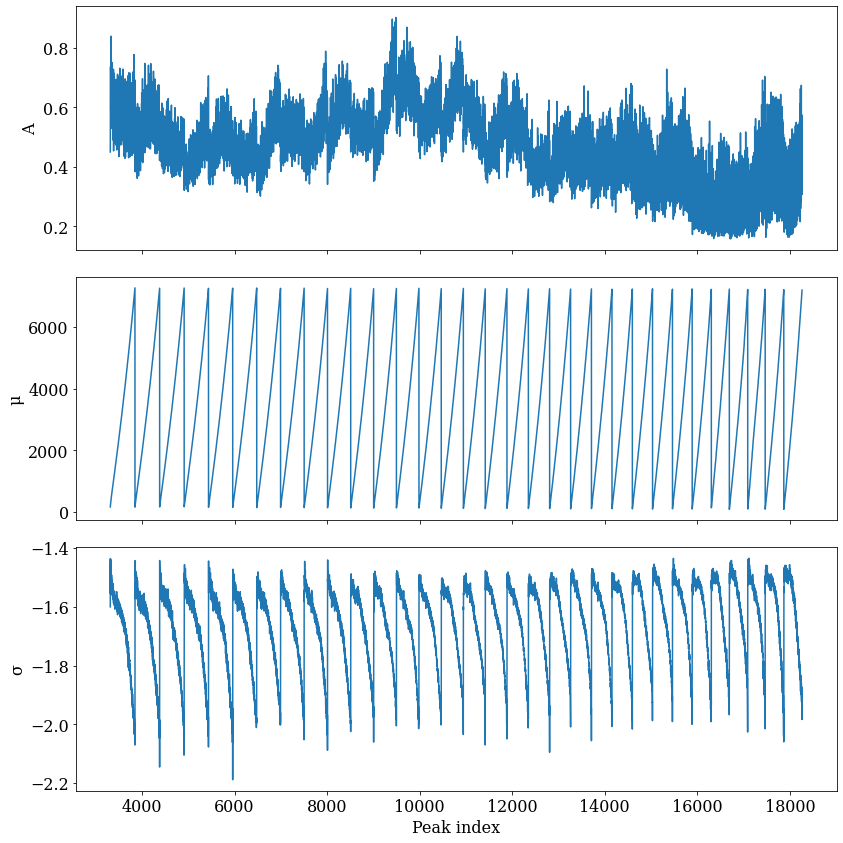

In [41]:
df_cropped = df[(df['order'] > 43) & (df['order'] < 76)]
fig, ax = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

# A 
ax[0].plot(df_cropped["A"].index, df_cropped["A"].values)
ax[0].set_ylabel("A")

# mu
ax[1].plot(df_cropped["μ"].index, df_cropped["μ"].values)
ax[1].set_ylabel("μ")

# sigma
ax[2].plot(df_cropped["σ"].index, df_cropped["σ"].values)
ax[2].set_ylabel("σ")
ax[2].set_xlabel("Peak index")

# fig.savefig("figures/fit_params.png", dpi=300)
fig.tight_layout()

### Fit peak positions

In [79]:
peak_pos_residuals = []
peak_pos_chi2 = []
for result in results:
    order, peak_fit, wavel_true, wavel_given = result
    
    # Some requirements
    
    if np.isnan(peak_fit).all(): # leave out orders with no peaks 
        continue

    if order < 30:
        continue

    if len(peak_fit) < 30:
        continue
    
    # Strip first and last 10 peaks
    # peak_fit = peak_fit[10:-10]
    # wavel_true = wavel_true[10:-10]
    # wavel_given = wavel_given[10:-10]

    # Fit peak positions
    peak_pos_fit = fit_peak_positions(wavel_true[:, 0], peak_fit)

    # Compute fit residual
    x = peak_fit[:,2]
    # residual = wavel_true[:, 0] - peak_position_fit_func(x, *peak_pos_fit[0])
    residual = peak_position_fit_func(x, *peak_pos_fit[0]) - wavel_true[:, 0] 
    peak_pos_residuals.append(residual)
    peak_pos_chi2.append(peak_pos_fit[1])
    
    # Plot all orders
    # plt.figure(figsize=(8,4))
    # plt.plot(x, residual, ".")
    # plt.title(f"{order}. order (chi2 = {peak_pos_fit[1]:.3})")
    # # plt.xlabel("Pixel peak position")
    # # plt.ylabel("$\lambda_{true} - \lambda_{fit} $ / Å")
    # plt.ylabel("$\lambda_{fit} - \lambda_{true}$ / Å")


peak_pos_residuals = np.asarray(peak_pos_residuals, dtype=object)
peak_pos_residuals = np.concatenate(peak_pos_residuals) # flatten array
peak_pos_chi2 = np.asarray(peak_pos_chi2)

# Save residuals to .csv
# np.savetxt("fit_results/residuals_5degree_fit.csv", peak_pos_residuals, delimiter=",")

print(f"chi2 mean is {np.mean(peak_pos_chi2):.3}")
print(f"chi2 median is {np.median(peak_pos_chi2):.3}")
print(f"chi2 max is {np.max(peak_pos_chi2):.3}")
print(f"chi2 min is {np.min(peak_pos_chi2):.3}")
# print(peak_pos_chi2)

chi2 mean is 3.04e+10
chi2 median is 6.87e-05
chi2 max is 9.85e+11
chi2 min is 5.17e-06


### Plot distribution of peak residuals ($\lambda_{fit} - \lambda_{true} $)


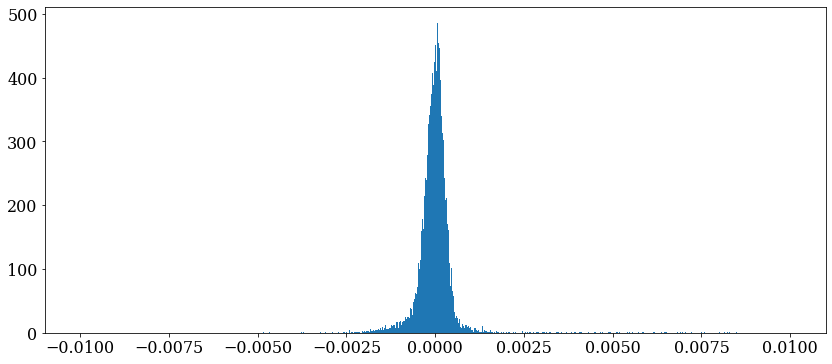

In [80]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.hist(peak_pos_residuals, bins=1000, range=(-10e-3, 10e-3));
# fig.savefig("figures/peak_residuals.png", dpi=300)